In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow.keras as keras

In [4]:
nn_model = tf.keras.models.load_model('/arc/home/aydanmckay/ml/green2020-stellar-model/green2020_nn_model.h5')
nn_model.summary()

Model: "green2020_stellar_photometry_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 theta (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 stellar_model_hidden_1 (Dense)  (None, 32)          128         ['theta[0][0]']                  
                                                                                                  
 E (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 R (Dense)                      (None, 13)           52          ['theta[0][0]']                  
                                                                 

In [6]:
import json

with open('/arc/home/aydanmckay/ml/green2020-stellar-model/green2020_theta_normalization.json', 'r') as f:
    d = json.load(f)

theta_med = np.array(d['theta_med'])
theta_std = np.array(d['theta_std'])

def normalize_theta(theta):
    """
    Normalizes spectroscopic labels, so that they can be input to neural
    network.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
    
    Returns:
      Normalized theta. The normalization is based on the mean and standard
      deviation of theta in the training dataset.
    """
    # theta_med = np.array([5372.02, 4.06696, -0.246082])
    # theta_std = np.array([902.802, 0.889269, 0.373921])
    x = (theta - theta_med[None,:]) / theta_std[None,:]
    return x

In [7]:
inputs = [
    nn_model.get_layer('theta').input,
    nn_model.get_layer('E').input
]
outputs = nn_model.get_layer(name='B_M_plus_A').output
B_M_plus_A_model = tf.keras.Model(inputs, outputs)

def predict_mag_color(theta, E):
    """
    Predicts extinguished absolute magnitude and colors, B(M+A), for
    a given set of spectroscopic labels, theta, and reddenings, E.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
      E (numpy.ndarray): Array containing reddening for each star (in an
          arbitrary unit, similar to the scale used by SFD'98).
          Shape = (# of stars,).
    
    Outputs:
      B(M+A), as a numpy.ndarray. Shape = (# of stars, 13).
    """
    x = normalize_theta(theta)
    E = np.reshape(E, (E.size,1))
    return B_M_plus_A_model([x, E]).numpy()

In [8]:
predict_mag_color(np.array([[5780., 4.44, 0.0]]), np.array([1.]))

array([[ 7.270337  ,  1.1075447 , -1.1917646 ,  1.5100715 ,  0.0517581 ,
        -0.7712098 , -1.2628957 , -1.5787518 , -2.9126177 , -3.578178  ,
        -3.8257399 , -1.3119248 , -0.65782475]], dtype=float32)

In [10]:
def input_grid(n_teff, n_logg, feh=0.):
    """
    Generates a grid in T_eff, logg, with constant [Fe/H].
    Also returns a vector of zeros for the reddenings.

    Inputs:
      n_teff (int): The # of grid points for T_eff.
      n_logg (int): The # of grid points for logg.
      feh (float): Constant [Fe/H] to fill grid with.

    Returns:
      theta (np.ndarray): A vector containing (T_eff, logg, [Fe/H]).
        Shape = (# of grid points, 3).
      E (np.ndarray): A zero-filled vector. Shape = (# of grid points,).
    """
    # Grid in (teff, logg)
    teff = np.linspace(3500., 8500., n_teff)
    logg = np.linspace(0., 6., n_logg)
    teff, logg = np.meshgrid(teff, logg)

    # [Fe/H] = 0
    feh0 = np.full_like(teff, feh)

    # Pack spectroscopic labels into one array
    theta = np.stack([teff, logg, feh0], axis=-1)
    theta.shape = (theta.shape[0]*theta.shape[1], 3)

    # Zero reddening
    E = np.zeros(theta.shape[0])

    return theta, E

In [11]:
theta, E = input_grid(100, 100)

BM = predict_mag_color(theta, E)

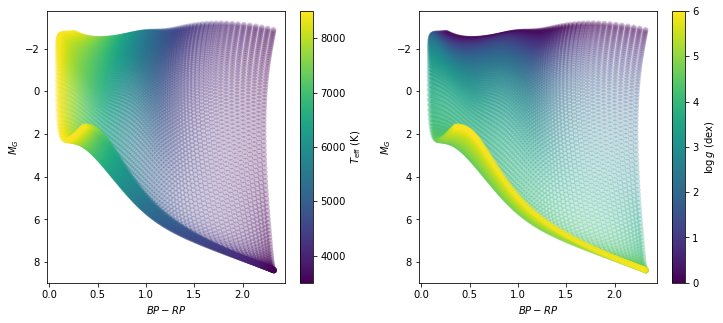

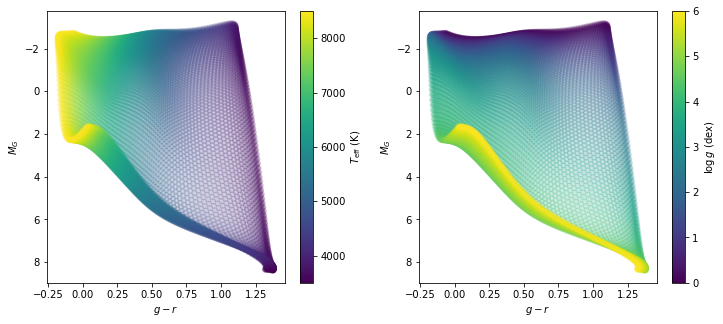

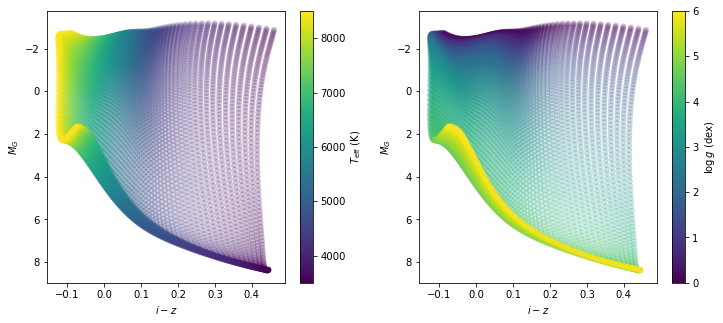

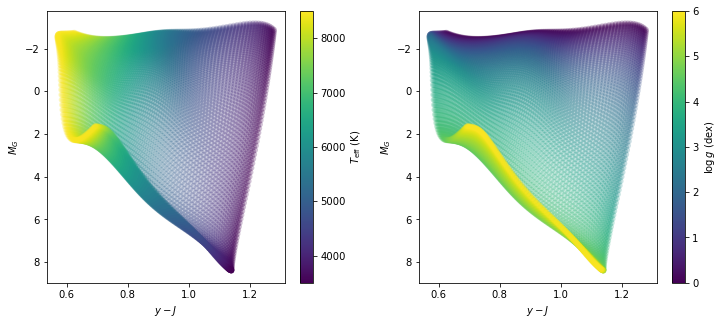

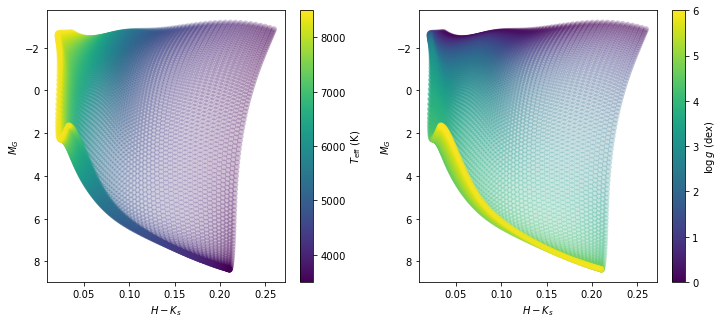

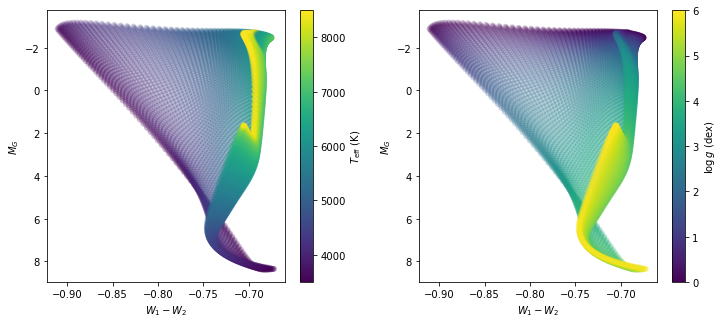

In [12]:
# All the bands (except G)
bands = ['BP', 'RP'] + list('grizyJH') + ['K_s', 'W_1', 'W_2']

# Plot each color
for k,(b1,b2) in enumerate(zip(bands[:-1:2],bands[1::2])):
    fig,ax_arr = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.25)

    # Plot both T_eff and logg
    theta_labels = [
        r'$T_{\mathrm{eff}}\ \left( \mathrm{K} \right)$',
        r'$\log g\ \left( \mathrm{dex} \right)$'
    ]
    for i,(ax,label) in enumerate(zip(ax_arr, theta_labels)):
        im = ax.scatter(
            BM[:,2*k+1]-BM[:,2*k+2],
            BM[:,0],
            c=theta[:,i],
            alpha=0.25,
            edgecolors='none'
        )
        cb = fig.colorbar(im, ax=ax, label=label)
        cb.set_alpha(1)
        cb.draw_all()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel(r'${}-{}$'.format(b1,b2))
        ax.set_ylabel(r'$M_G$')
    
    plt.show()

In [27]:
import h5py
from scipy.interpolate import RegularGridInterpolator

with h5py.File('/arc/home/aydanmckay/ml/green2020-stellar-model/green2020_input_density.h5', 'r') as f:
    rho_stars = f['rho_stars'][:] # Density grid
    # Grid coordinates
    teff_range = f['rho_stars'].attrs['teff'][:]
    logg_range = f['rho_stars'].attrs['logg'][:]
    feh_range = f['rho_stars'].attrs['feh'][:]

# Construct interpolator for each band
grid = (teff_range, logg_range, feh_range)
rho_stars_interp = [
    RegularGridInterpolator(grid, rs, fill_value=0., bounds_error=False)
    for rs in rho_stars
]

def get_input_density(theta, band):
    """
    Returns the relative density of training data at the given points
    theta, for the given band.

    Inputs:
      theta (np.ndarray): Points in theta-space at which to evaluate the
          density of stars in the input dataset.
      band (int): Which band to evaluate the density for. 0 = parallax,
          1 = BP, 2 = RP, 3 = g, etc.
    
    Returns:
      The relative density of stars observed in the given band at the
      given points in theta-space in the input catalog that we used to
      train the model. The densities are normalized such that the maximum
      density for each band is 1.
    """
    return rho_stars_interp[band](theta)

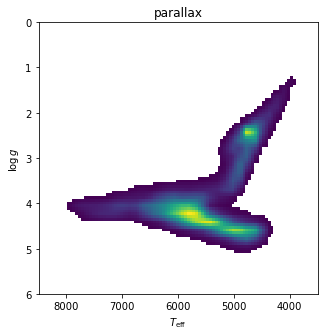

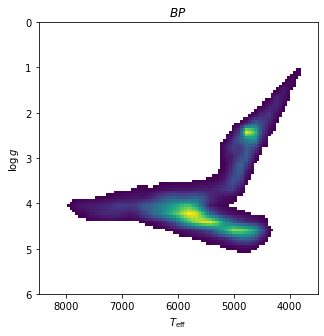

In [28]:
theta_grid,_ = input_grid(100, 100, feh=0.)

for b,title in enumerate(('parallax', r'$BP$')):
    img = get_input_density(theta_grid, b).reshape(100,100)
    img[img < 1.e-2] = np.nan # Make a cut on minimum density
    
    fig,ax = plt.subplots(1,1, figsize=(5,5))
    extent = (
        np.min(theta_grid[:,0]),
        np.max(theta_grid[:,0]),
        np.min(theta_grid[:,1]),
        np.max(theta_grid[:,1]),
    )
    ax.imshow(
        img,
        origin='lower',
        interpolation='nearest',
        extent=extent,
        aspect='auto'
    )
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel(r'$T_{\mathrm{eff}}$')
    ax.set_ylabel(r'$\log g$')
    ax.set_title(title)

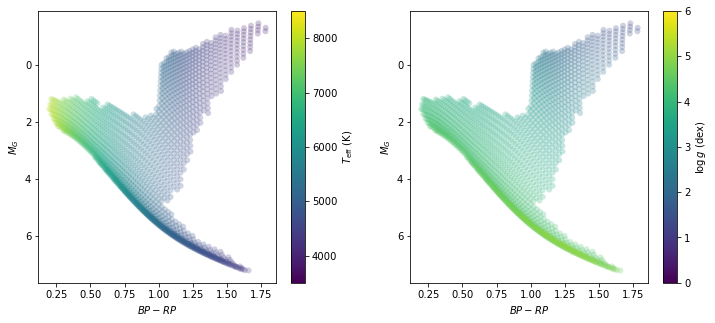

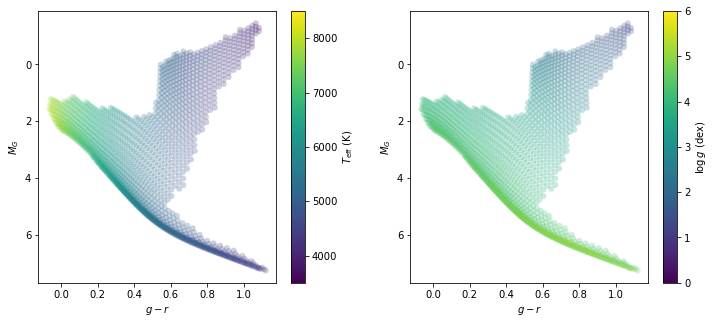

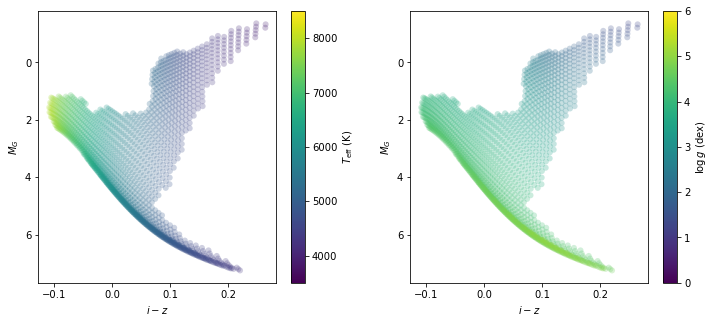

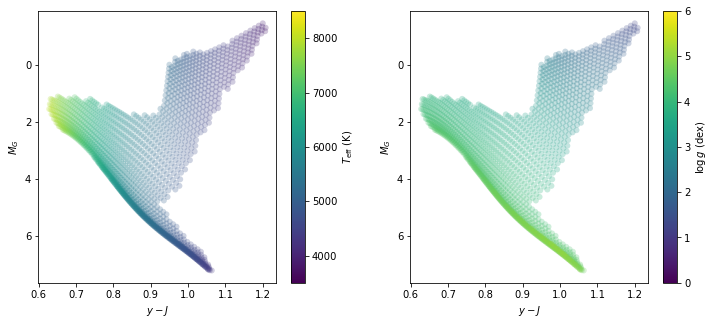

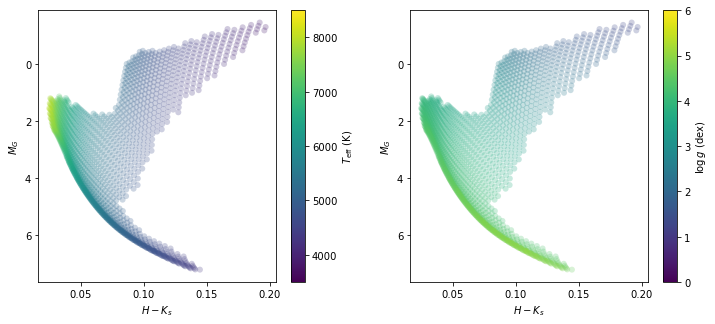

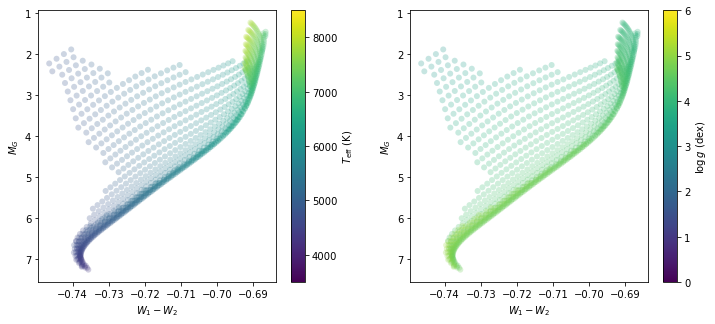

In [29]:
theta, E = input_grid(100, 100)
BM = predict_mag_color(theta, E)

# All the bands (except G)
bands = ['BP', 'RP'] + list('grizyJH') + ['K_s', 'W_1', 'W_2']

# We need parallax measurements to learn absolute magnitudes in G.
# We'll use a relative density of 0.01 as the threshold.
idx_G = (get_input_density(theta, 0) > 1.e-2)

# Plot each color
for k,(b1,b2) in enumerate(zip(bands[:-1:2],bands[1::2])):
    fig,ax_arr = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.25)
    
    # Determine region of applicability of the model in bands b1 and b2
    idx = (
        idx_G
        & (get_input_density(theta, 2*k+1) > 1.e-2)
        & (get_input_density(theta, 2*k+2) > 1.e-2)
    )

    # Plot both T_eff and logg
    theta_labels = [
        r'$T_{\mathrm{eff}}\ \left( \mathrm{K} \right)$',
        r'$\log g\ \left( \mathrm{dex} \right)$'
    ]
    for i,(ax,label) in enumerate(zip(ax_arr, theta_labels)):
        vmin,vmax = np.min(theta[:,i]), np.max(theta[:,i])

        im = ax.scatter(
            BM[idx,2*k+1]-BM[idx,2*k+2],
            BM[idx,0],
            c=theta[idx,i],
            alpha=0.25,
            edgecolors='none',
            vmin=vmin,
            vmax=vmax
        )
        cb = fig.colorbar(im, ax=ax, label=label)
        cb.set_alpha(1)
        cb.draw_all()
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel(r'${}-{}$'.format(b1,b2))
        ax.set_ylabel(r'$M_G$')
    
    plt.show()

In [30]:
inputs = nn_model.get_layer('theta').input
outputs = nn_model.get_layer(name='R').output
R_model = tf.keras.Model(inputs, outputs)

def predict_R(theta):
    """
    Predicts the reddening vector, R, for a given set of
    spectroscopic labels, theta.

    Inputs:
      theta (numpy.ndarray): Array containing (T_eff, logg, [Fe/H]) in
          units of (K, dex, dex) for each star. Shape = (# of stars, 3).
    
    Outputs:
      R, the reddening vector. Shape = (# of stars, 13).
    """
    x = normalize_theta(theta)
    return R_model(x).numpy()

In [31]:
theta, E = input_grid(20, 20)

BM = predict_mag_color(theta, E)
R = predict_R(theta)

# Range of applicability of the model
idx = (
    (get_input_density(theta, 1) > 1.e-2)
    & (get_input_density(theta, 2) > 1.e-2)
)

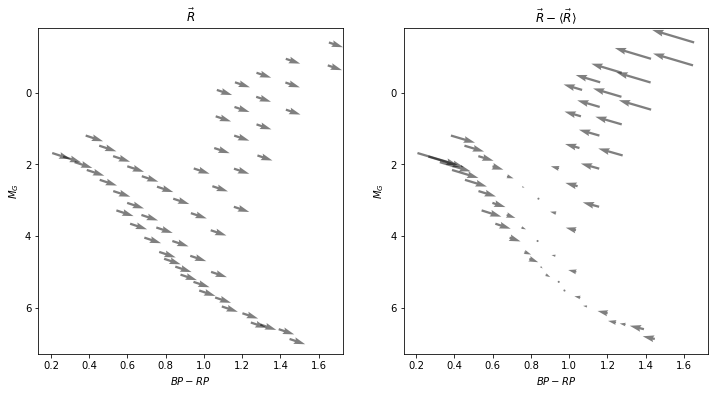

In [32]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.quiver(
    BM[idx,1]-BM[idx,2], # BP-RP
    BM[idx,0], # M_G
    R[idx,1]-R[idx,2], # R_BP - R_RP
    R[idx,0], # R_G
    angles='xy',
    alpha=0.5
)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlabel(r'$BP-RP$'.format(b1,b2))
ax1.set_ylabel(r'$M_G$')
ax1.set_title(r'$\vec{R}$')

R0 = np.mean(R, axis=0)
dR = R - R0[None,:]
ax2.quiver(
    BM[idx,1]-BM[idx,2], # BP-RP
    BM[idx,0], # M_G
    dR[idx,1]-dR[idx,2], # R_BP - R_RP
    dR[idx,0], # R_G
    angles='xy',
    alpha=0.5
)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel(r'$BP-RP$'.format(b1,b2))
ax2.set_ylabel(r'$M_G$')
ax2.set_title(r'$\vec{R} - \langle \vec{R} \rangle$')

plt.show()

In [34]:
with h5py.File('/arc/home/aydanmckay/ml/green2020-stellar-model/green2020_test_data_small.h5', 'r') as f:
    d = f['data'][:]       # All the data needed to train or test the model
    r_fit = f['r_fit'][:]  # The reddening inferred using the trained model
    r_var = f['r_var'][:]  # The variance of the inferred reddening

print(d.dtype.names)

('atm_param', 'atm_param_cov', 'atm_param_p', 'atm_param_cov_p', 'r', 'r_err', 'mag', 'mag_err', 'parallax', 'parallax_err', 'atm_source', 'r_source')


In [35]:
def get_cov(use_r_fit=False):
    n_stars, n_bands = d['mag'].shape

    large_err = 999. # A large error, in magnitudes

    # Observed y = B(m - distmod) and its covariance
    y = d['mag'].copy() # Begin with observed apparent magnitudes
    cov_y = np.zeros((n_stars, n_bands, n_bands))

    # Photometric contribution to covariance: sigma_m^2
    for b in range(n_bands):
        cov_y[:,b,b] = d['mag_err'][:,b]**2

    # Replace unobserved mags with median, and blow up corresponding errors
    for b in range(n_bands):
        idx = ~np.isfinite(y[:,b]) | ~np.isfinite(cov_y[:,b,b])
        y[idx,b] = np.nanmedian(y[:,b])
        cov_y[idx,b,b] = large_err**2.

    # Transform both y and its covariance to (mag,color)-space
    B = np.identity(n_bands, dtype='f4')
    B[1:,0] = -1.

    y = np.einsum('ij,nj->ni', B, y) # y' = B y
    # C' = B C B^T
    cov_y = np.einsum('nik,jk->nij', cov_y, B)
    cov_y = np.einsum('ik,nkj->nij', B, cov_y)

    # Subtract distance modulus from G-band apparent magnitude
    dm = 10. - 5.*np.log10(d['parallax'])
    y[:,0] -= dm

    # Parallax contribution to covariance
    err_over_plx = d['parallax_err'] / d['parallax']
    cov_y[:,0,0] += (5./np.log(10.) * err_over_plx)**2.

    # Don't attempt to predict M_G for poor plx/err or when plx < 0
    idx = (
          (err_over_plx > 0.2)
        | (d['parallax'] < 1.e-8)
        | ~np.isfinite(d['parallax'])
        | ~np.isfinite(d['parallax_err'])
    )
    cov_y[idx,0,0] = large_err**2
    y[idx,0] = np.nanmedian(y[:,0])

    # Reddening contribtion to covariance: sigma_r^2 (BR) (BR)^T
    R = predict_R(d['atm_param_p'])
    BR = np.einsum('ij,nj->ni', B, R)
    if use_r_fit:
        cov_y += (d['r_err']**2)[:,None,None] * BR[:,:,None] * BR[:,None,:]
    else:
        cov_y += r_var[:,None,None] * BR[:,:,None] * BR[:,None,:]

    # Theta contribution to covariance: J C_theta J^T,
    # where J := d[B(M+ER)]/dtheta
    with tf.GradientTape() as g:
        x_p = tf.constant(d['atm_param_p'])
        if use_r_fit:
            E = tf.constant(r_fit)
        else:
            E = tf.constant(d['r'])
        g.watch(x_p)
        mag_color = B_M_plus_A_model([x_p, E]) # Forward pass through model
    J = g.batch_jacobian(mag_color, x_p).numpy() # Calculate Jacobian
    cov_y += np.einsum('nik,nkl,njl->nij', J, d['atm_param_cov_p'], J)

    return y, cov_y

In [36]:
y, cov_y = get_cov()

/tmp/ipykernel_199/2306404195.py:30: RuntimeWarning: invalid value encountered in log10
  dm = 10. - 5.*np.log10(d['parallax'])


In [37]:
def get_LT(cov_y):
    inv_cov_y = np.empty_like(cov_y)
    LT = np.empty_like(cov_y)
    LTy = np.empty_like(y) # L^T y, where y := B(m-distmod)

    for k,c in enumerate(cov_y):
        # Inflate diagonal of cov slightly, to ensure
        # positive-definiteness
        c_diag = c[np.diag_indices_from(c)]
        c[np.diag_indices_from(c)] += 1.e-4 + 1.e-3 * c_diag

        inv_cov_y[k] = np.linalg.inv(c)
        LT[k] = np.linalg.cholesky(inv_cov_y[k]).T

    LTy = np.einsum('nij,nj->ni', LT, y)

    return LT, LTy

In [38]:
LT, LTy = get_LT(cov_y)

In [39]:
def get_loss(theta, r, LT, LTy):
    inputs = [theta, r, LT]
    outputs = LTy

    loss,mse = nn_model.evaluate(
        inputs,
        outputs,
        batch_size=32,
        verbose=0
    )

    return loss,mse

for r_source in ['sfd', 'b19', 'default']:
    idx = [rs.decode() == r_source for rs in d['r_source']]
    loss,mse = get_loss(d['atm_param_p'][idx], d['r'][idx], LT[idx], LTy[idx])
    n = np.count_nonzero(idx)

    print(f'Reddening estimate comes from {r_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

Reddening estimate comes from sfd (n = 3965):
               mse (chi^2/band) = 0.7122
    loss (mse + regularization) = 0.7268

Reddening estimate comes from b19 (n = 5086):
               mse (chi^2/band) = 1.3706
    loss (mse + regularization) = 1.3852

Reddening estimate comes from default (n = 949):
               mse (chi^2/band) = 17.9712
    loss (mse + regularization) = 17.9858



In [40]:
idx_r = np.array([rs.decode() == 'sfd' for rs in d['r_source']])

for atm_source in ['lamost', 'apogee', 'galah']:
    idx_atm = np.array([rs.decode() == atm_source for rs in d['atm_source']])
    idx = idx_r & idx_atm
    loss,mse = get_loss(d['atm_param_p'][idx], d['r'][idx], LT[idx], LTy[idx])
    n = np.count_nonzero(idx)

    print(f'Spectroscopic labels come from {atm_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

Spectroscopic labels come from lamost (n = 3511):
               mse (chi^2/band) = 0.7303
    loss (mse + regularization) = 0.7449

Spectroscopic labels come from apogee (n = 247):
               mse (chi^2/band) = 0.6907
    loss (mse + regularization) = 0.7053

Spectroscopic labels come from galah (n = 207):
               mse (chi^2/band) = 0.4309
    loss (mse + regularization) = 0.4455



In [41]:
y, cov_y = get_cov(use_r_fit=True)
LT, LTy = get_LT(cov_y)

for r_source in ['sfd', 'b19', 'default']:
    idx = [rs.decode() == r_source for rs in d['r_source']]
    loss,mse = get_loss(d['atm_param_p'][idx], r_fit[idx], LT[idx], LTy[idx])

    n = np.count_nonzero(idx)

    print(f'Original reddening estimate comes from {r_source} (n = {n}):')
    print(f'               mse (chi^2/band) = {mse:.4f}')
    print(f'    loss (mse + regularization) = {loss:.4f}')
    print()

/tmp/ipykernel_199/2306404195.py:30: RuntimeWarning: invalid value encountered in log10
  dm = 10. - 5.*np.log10(d['parallax'])


Original reddening estimate comes from sfd (n = 3965):
               mse (chi^2/band) = 0.5391
    loss (mse + regularization) = 0.5536

Original reddening estimate comes from b19 (n = 5086):
               mse (chi^2/band) = 0.8270
    loss (mse + regularization) = 0.8416

Original reddening estimate comes from default (n = 949):
               mse (chi^2/band) = 2.4969
    loss (mse + regularization) = 2.5115

